In [1]:
!nvidia-smi

Mon Sep 07 11:38:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:09:00.0  On |                  N/A |
| 30%   54C    P0    28W / 108W |    633MiB /  3072MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

from tensorflow import keras
from keras.callbacks.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Layer, Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed, BatchNormalization, Conv1D
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def reverse_gradient(X, hp_lambda):
    '''Flips the sign of the incoming gradient during training.'''
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Identity': grad_name}):
        y = tf.identity(X)

    return y

class GradientReversal(Layer):
    '''Flip the sign of gradient during training.'''
    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def get_config(self):
        config = {'hp_lambda': self.hp_lambda}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
df = pd.read_csv('KAG_energydata_complete_2.csv', sep=',')
df = df.drop('Unnamed: 0', axis = 1)
df = df.drop('date', axis = 1)

In [5]:
cols = df.columns

In [6]:
df2 = pd.read_csv('HomeC_3.csv', sep=',')
df2 = df2.drop('Unnamed: 0', axis = 1)

In [7]:
cols2 = ['temperature', 'pressure', 'humidity', 'windSpeed', 'visibility', 'dewPoint', 'House overall [kW]']
df2 = df2[cols2]

In [8]:
#StandardScaler
#MinMaxScaler

x = df[cols].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns = cols)

In [9]:
x2 = df2[cols2].values #returns a numpy array
min_max_scaler_2 = preprocessing.MinMaxScaler()
x_scaled2 = min_max_scaler_2.fit_transform(x2)
df2 = pd.DataFrame(x_scaled2, columns = cols2)

In [10]:
df.describe()

,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,HouseConsum
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,0.399089,0.609828,0.733558,0.288554,0.574321,0.468810,0.083179
std,0.170978,0.172080,0.196067,0.175087,0.181457,0.189803,0.094892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278671,0.503101,0.609649,0.142857,0.430769,0.339367,0.036364
50%,0.383173,0.623256,0.785088,0.261905,0.600000,0.453997,0.045455
75%,0.495445,0.735659,0.890351,0.392857,0.600000,0.595777,0.081818
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df2.describe()

,temperature,pressure,humidity,windSpeed,visibility,dewPoint,House overall [kW]
count,50391.000000,50391.000000,50391.000000,50391.000000,50391.000000,50391.000000,50391.000000
mean,0.595919,0.533386,0.628335,0.290263,0.923273,0.641818,0.076457
std,0.179682,0.140824,0.228509,0.173411,0.165216,0.185799,0.082721
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.455152,0.444078,0.447647,0.159777,0.940391,0.504517,0.035400
50%,0.592046,0.537460,0.647059,0.258402,1.000000,0.645089,0.054622
75%,0.741820,0.625758,0.830588,0.389786,1.000000,0.798501,0.089234
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
timestep = 1

X_small = df[0:13812]
y_small = X_small['HouseConsum'].shift(-timestep,axis=0)[:-timestep]
X_small = X_small[:-timestep]

print(X_small.shape, y_small.shape)

X_small = sequence.pad_sequences(X_small.values.tolist(), dtype='float32')

X_small = np.reshape(X_small, (int(X_small.shape[0]/timestep), timestep, X_small.shape[1]))

y_small = y_small.tolist()

X_val = df[13812:-7] #13812:-7
y_val = X_val['HouseConsum'].shift(-timestep,axis=0)[:-timestep]
X_val = X_val[:-timestep]

X_val = sequence.pad_sequences(X_val.values.tolist(), dtype='float32')

X_val = np.reshape(X_val, (int(X_val.shape[0]/timestep), timestep, X_val.shape[1]))

y_val = y_val.tolist()


(13811, 7) (13811,)


In [13]:
X_big = df2[0:-3]
y_big = X_big['House overall [kW]'].shift(-timestep,axis=0)[:-timestep]
X_big = X_big[:-timestep]

print(X_big.shape, y_big.shape)

X_big = sequence.pad_sequences(X_big.values.tolist(), dtype='float32')

X_big = np.reshape(X_big, (int(X_big.shape[0]/timestep), timestep, X_big.shape[1]))

y_big = y_big.tolist()

(50387, 7) (50387,)


In [13]:
#IF TIME STEP > 1 THEN RUN THIS
y_small = sequence.pad_sequences([y_small], dtype='float32')
y_small = np.reshape(y_small, (int(y_small.shape[1]/timestep), timestep, 1))

y_val = sequence.pad_sequences([y_val], dtype='float32')
y_val = np.reshape(y_val, (int(y_val.shape[1]/timestep), timestep, 1))

y_big = sequence.pad_sequences([y_big], dtype='float32')
y_big = np.reshape(y_big, (int(y_big.shape[1]/timestep), timestep, 1))

In [14]:
#IF TIME STEP == 1 THEN RUN THIS
y_small = np.array(y_small)

y_val = np.array(y_val)

y_big = np.array(y_big)

In [15]:
d_size = int(len(X_big)/timestep*(0.16))

X_big1 = X_big[0:d_size]
X_big2 = X_big[d_size:int(d_size*2)]
X_big3 = X_big[int(d_size*2):int(d_size*3)]
X_big4 = X_big[int(d_size*3):int(d_size*4)]
X_big5 = X_big[int(d_size*4):int(d_size*5)]
X_big6 = X_big[int(d_size*5):int(d_size*6)]

y_big1 = y_big[0:d_size]
y_big2 = y_big[d_size:int(d_size*2)]
y_big3 = y_big[int(d_size*2):int(d_size*3)]
y_big4 = y_big[int(d_size*3):int(d_size*4)]
y_big5 = y_big[int(d_size*4):int(d_size*5)]
y_big6 = y_big[int(d_size*5):int(d_size*6)]

In [16]:
d_size = int(len(X_small)/timestep*(0.16))

X_small1 = X_small[0:d_size]
X_small2 = X_small[d_size:int(d_size*2)]
X_small3 = X_small[int(d_size*2):int(d_size*3)]
X_small4 = X_small[int(d_size*3):int(d_size*4)]
X_small5 = X_small[int(d_size*4):int(d_size*5)]
X_small6 = X_small[int(d_size*5):int(d_size*6)]

y_small1 = y_small[0:d_size]
y_small2 = y_small[d_size:int(d_size*2)]
y_small3 = y_small[int(d_size*2):int(d_size*3)]
y_small4 = y_small[int(d_size*3):int(d_size*4)]
y_small5 = y_small[int(d_size*4):int(d_size*5)]
y_small6 = y_small[int(d_size*5):int(d_size*6)]

In [17]:
X_list_big = [X_big1, X_big2, X_big3, X_big4, X_big5, X_big6]
y_list_big = [y_big1, y_big2, y_big3, y_big4, y_big5, y_big6]

In [18]:
X_list_small = [X_small1, X_small2, X_small3, X_small4, X_small5, X_small6]
y_list_small = [y_small1, y_small2, y_small3, y_small4, y_small5, y_small6]

In [19]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
from datetime import datetime
today = str(datetime.now().strftime("%d/%m/%Y %H:%M"))
today = today.replace('/', '_')
today = today.replace(':', ';')
today = today.replace(' ', '_')

newpath = 'C:/Users/Anton/Desktop/Exjobb MSC/graph_ex/'+today
if not os.path.exists(newpath):
    os.makedirs(newpath)

Train...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Bidirectional)        (None, 1, 14)             840       
_________________________________________________________________
bi-lstm1 (Bidirectional)     (None, 1, 14)             1232      
_________________________________________________________________
bi-lstm2 (Bidirectional)     (None, 1, 14)             1232      
_________________________________________________________________
bi-lstm3 (Bidirectional)     (None, 1, 14)             1232      
_________________________________________________________________
bi-lstm4 (Bidirectional)     (None, 1, 14)             1232      
_________________________________________________________________
Normalization (BatchNormaliz (None, 1, 14)             56        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 14)   

2209/2209 [==============================] - 0s 11us/step - loss: 0.0062 - r2: 0.5280 - val_loss: 0.0042 - val_r2: 0.5492
Epoch 51/1000
2209/2209 [==============================] - 0s 11us/step - loss: 0.0062 - r2: 0.5716 - val_loss: 0.0042 - val_r2: 0.5492
Epoch 52/1000
2209/2209 [==============================] - 0s 11us/step - loss: 0.0062 - r2: 0.5255 - val_loss: 0.0042 - val_r2: 0.5492
Epoch 53/1000
2209/2209 [==============================] - 0s 12us/step - loss: 0.0064 - r2: 0.5456 - val_loss: 0.0042 - val_r2: 0.5492
Epoch 54/1000
2209/2209 [==============================] - 0s 11us/step - loss: 0.0063 - r2: 0.5195 - val_loss: 0.0042 - val_r2: 0.5492
Epoch 55/1000
2209/2209 [==============================] - 0s 12us/step - loss: 0.0063 - r2: 0.5432 - val_loss: 0.0042 - val_r2: 0.5492
Epoch 56/1000
2209/2209 [==============================] - 0s 11us/step - loss: 0.0065 - r2: 0.5302 - val_loss: 0.0042 - val_r2: 0.5492
Epoch 57/1000
2209/2209 [==============================] - 0s 

Train on 2209 samples, validate on 2209 samples
Epoch 1/1000
2209/2209 [==============================] - 5s 2ms/step - loss: 0.0062 - r2: 0.5481 - val_loss: 0.0041 - val_r2: 0.5493
Epoch 2/1000
2209/2209 [==============================] - 0s 39us/step - loss: 0.0062 - r2: 0.5833 - val_loss: 0.0041 - val_r2: 0.5493
Epoch 3/1000
2209/2209 [==============================] - 0s 38us/step - loss: 0.0063 - r2: 0.5492 - val_loss: 0.0041 - val_r2: 0.5493
Epoch 4/1000
2209/2209 [==============================] - 0s 36us/step - loss: 0.0063 - r2: 0.5411 - val_loss: 0.0041 - val_r2: 0.5493
Epoch 5/1000
2209/2209 [==============================] - 0s 38us/step - loss: 0.0061 - r2: 0.5482 - val_loss: 0.0041 - val_r2: 0.5492
Epoch 6/1000
2209/2209 [==============================] - 0s 40us/step - loss: 0.0061 - r2: 0.5742 - val_loss: 0.0041 - val_r2: 0.5491
Epoch 7/1000
2209/2209 [==============================] - 0s 39us/step - loss: 0.0062 - r2: 0.5631 - val_loss: 0.0041 - val_r2: 0.5490
Epoch 8/

Train on 4418 samples, validate on 2209 samples
Epoch 1/1000
4418/4418 [==============================] - 1s 202us/step - loss: 0.0047 - r2: 0.6114 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 2/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0049 - r2: 0.5894 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 3/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0050 - r2: 0.5888 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 4/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0049 - r2: 0.5907 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 5/1000
4418/4418 [==============================] - 0s 8us/step - loss: 0.0048 - r2: 0.5995 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 6/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0050 - r2: 0.5826 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 7/1000
4418/4418 [==============================] - 0s 8us/step - loss: 0.0050 - r2: 0.5934 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 8/1000

4418/4418 [==============================] - 0s 8us/step - loss: 0.0050 - r2: 0.5810 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 62/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0050 - r2: 0.6052 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 63/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0048 - r2: 0.6079 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 64/1000
4418/4418 [==============================] - 0s 8us/step - loss: 0.0050 - r2: 0.5974 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 65/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0048 - r2: 0.6023 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 66/1000
4418/4418 [==============================] - 0s 7us/step - loss: 0.0049 - r2: 0.6012 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 67/1000
4418/4418 [==============================] - 0s 8us/step - loss: 0.0050 - r2: 0.5954 - val_loss: 0.0040 - val_r2: 0.5116
Epoch 68/1000
4418/4418 [==============================] - 0s 7us/ste

Epoch 10/1000
4418/4418 [==============================] - 0s 30us/step - loss: 0.0049 - r2: 0.5913 - val_loss: 0.0040 - val_r2: 0.5155
Epoch 11/1000
4418/4418 [==============================] - 0s 32us/step - loss: 0.0050 - r2: 0.5975 - val_loss: 0.0040 - val_r2: 0.5157
Epoch 12/1000
4418/4418 [==============================] - 0s 31us/step - loss: 0.0050 - r2: 0.5848 - val_loss: 0.0040 - val_r2: 0.5159
Epoch 13/1000
4418/4418 [==============================] - 0s 28us/step - loss: 0.0050 - r2: 0.5954 - val_loss: 0.0040 - val_r2: 0.5161
Epoch 14/1000
4418/4418 [==============================] - 0s 30us/step - loss: 0.0049 - r2: 0.6006 - val_loss: 0.0040 - val_r2: 0.5163
Epoch 15/1000
4418/4418 [==============================] - 0s 29us/step - loss: 0.0049 - r2: 0.6014 - val_loss: 0.0040 - val_r2: 0.5164
Epoch 16/1000
4418/4418 [==============================] - 0s 30us/step - loss: 0.0050 - r2: 0.5967 - val_loss: 0.0040 - val_r2: 0.5166
Epoch 17/1000
4418/4418 [=======================

6627/6627 [==============================] - 0s 6us/step - loss: 0.0052 - r2: 0.5295 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 3/1000
6627/6627 [==============================] - 0s 7us/step - loss: 0.0051 - r2: 0.5291 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 4/1000
6627/6627 [==============================] - 0s 7us/step - loss: 0.0052 - r2: 0.5305 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 5/1000
6627/6627 [==============================] - 0s 7us/step - loss: 0.0051 - r2: 0.5381 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 6/1000
6627/6627 [==============================] - 0s 7us/step - loss: 0.0052 - r2: 0.5255 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 7/1000
6627/6627 [==============================] - 0s 7us/step - loss: 0.0051 - r2: 0.5400 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 8/1000
6627/6627 [==============================] - 0s 6us/step - loss: 0.0051 - r2: 0.5351 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 9/1000
6627/6627 [==============================] - 0s 7us/step - los

Epoch 63/1000
6627/6627 [==============================] - 0s 6us/step - loss: 0.0053 - r2: 0.5183 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 64/1000
6627/6627 [==============================] - 0s 6us/step - loss: 0.0051 - r2: 0.5347 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 65/1000
6627/6627 [==============================] - 0s 6us/step - loss: 0.0051 - r2: 0.5295 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 66/1000
6627/6627 [==============================] - 0s 6us/step - loss: 0.0052 - r2: 0.5314 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 67/1000
6627/6627 [==============================] - ETA: 0s - loss: 0.0055 - r2: 0.51 - 0s 6us/step - loss: 0.0052 - r2: 0.5231 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 68/1000
6627/6627 [==============================] - 0s 6us/step - loss: 0.0051 - r2: 0.5306 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 69/1000
6627/6627 [==============================] - 0s 6us/step - loss: 0.0051 - r2: 0.5303 - val_loss: 0.0036 - val_r2: 0.5230
Epoch 70/1000
6627/

6627/6627 [==============================] - 0s 28us/step - loss: 0.0052 - r2: 0.5261 - val_loss: 0.0038 - val_r2: 0.5051
Epoch 12/1000
6627/6627 [==============================] - 0s 30us/step - loss: 0.0051 - r2: 0.5299 - val_loss: 0.0038 - val_r2: 0.5038
Epoch 13/1000
6627/6627 [==============================] - 0s 31us/step - loss: 0.0051 - r2: 0.5364 - val_loss: 0.0038 - val_r2: 0.5025
Epoch 14/1000
6627/6627 [==============================] - 0s 29us/step - loss: 0.0051 - r2: 0.5342 - val_loss: 0.0038 - val_r2: 0.5013
Epoch 15/1000
6627/6627 [==============================] - 0s 29us/step - loss: 0.0052 - r2: 0.5262 - val_loss: 0.0038 - val_r2: 0.5002
Epoch 16/1000
6627/6627 [==============================] - 0s 29us/step - loss: 0.0051 - r2: 0.5316 - val_loss: 0.0038 - val_r2: 0.4991
Epoch 17/1000
6627/6627 [==============================] - 0s 28us/step - loss: 0.0051 - r2: 0.5413 - val_loss: 0.0038 - val_r2: 0.4982
Epoch 18/1000
6627/6627 [==============================] - 0s 

8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5197 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 39/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5259 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 40/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0049 - r2: 0.5208 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 41/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5296 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 42/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5247 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 43/1000
8836/8836 [==============================] - 0s 5us/step - loss: 0.0047 - r2: 0.5400 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 44/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5267 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 45/1000
8836/8836 [==============================] - 0s 7us/ste

Epoch 99/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5290 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 100/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5261 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 101/1000
8836/8836 [==============================] - 0s 6us/step - loss: 0.0048 - r2: 0.5270 - val_loss: 0.0043 - val_r2: 0.5611
Epoch 00101: early stopping
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Bidirectional)        (None, 1, 14)             840       
_________________________________________________________________
bi-lstm1 (Bidirectional)     (None, 1, 14)             1232      
_________________________________________________________________
bi-lstm2 (Bidirectional)     (None, 1, 14)             1232      
_________________________________________________________________
bi-lstm3 (Bidir

11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5219 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 14/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5298 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 15/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0046 - r2: 0.5559 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 16/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0046 - r2: 0.5467 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 17/1000
11045/11045 [==============================] - 0s 7us/step - loss: 0.0047 - r2: 0.5427 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 18/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5407 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 19/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5252 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 20/1000
11045/11045 [============================

11045/11045 [==============================] - 0s 6us/step - loss: 0.0046 - r2: 0.5308 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 73/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0046 - r2: 0.5502 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 74/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5303 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 75/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5368 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 76/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5353 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 77/1000
11045/11045 [==============================] - 0s 5us/step - loss: 0.0046 - r2: 0.5672 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 78/1000
11045/11045 [==============================] - 0s 6us/step - loss: 0.0047 - r2: 0.5015 - val_loss: 0.0036 - val_r2: 0.5003
Epoch 79/1000
11045/11045 [============================

Epoch 20/1000
11045/11045 [==============================] - 0s 30us/step - loss: 0.0046 - r2: 0.5667 - val_loss: 0.0038 - val_r2: 0.4863
Epoch 21/1000
11045/11045 [==============================] - 0s 29us/step - loss: 0.0046 - r2: 0.5551 - val_loss: 0.0038 - val_r2: 0.4865
Epoch 00021: early stopping
Good Model RMSE: 63.33676249333986  R^2: 0.5264479045172419  MAE: 26.579823778206933  MAPE: 22.593451469132376


<Figure size 1080x1080 with 0 Axes>

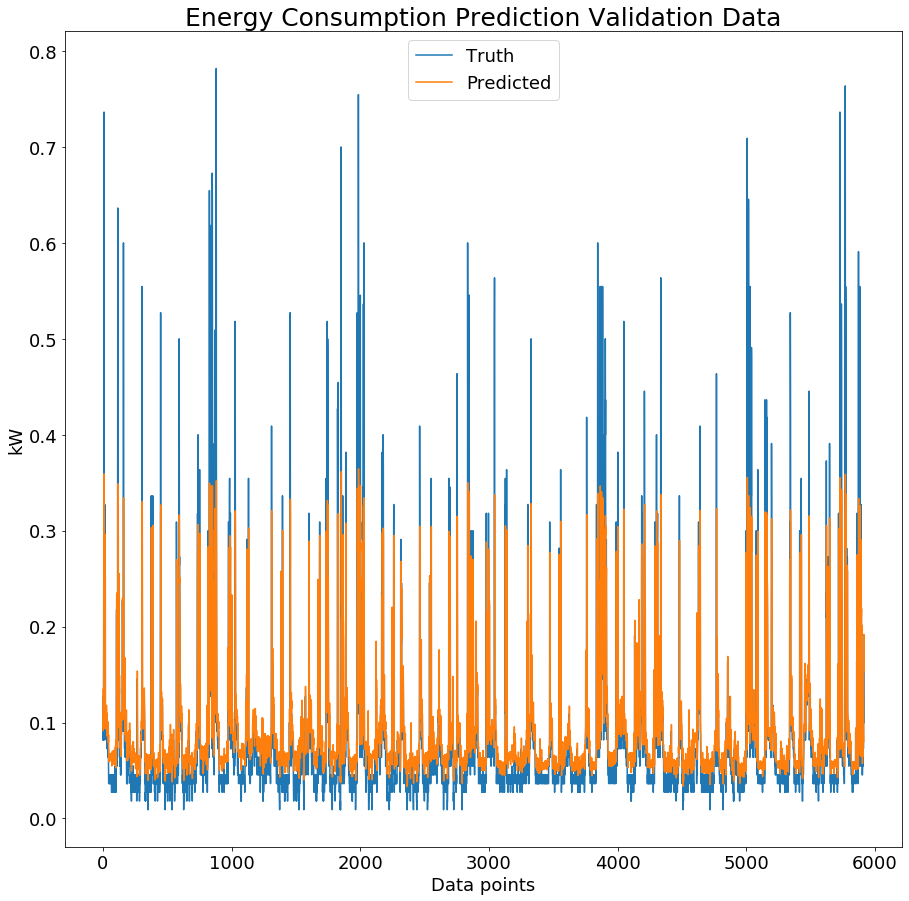

<Figure size 1080x1080 with 0 Axes>

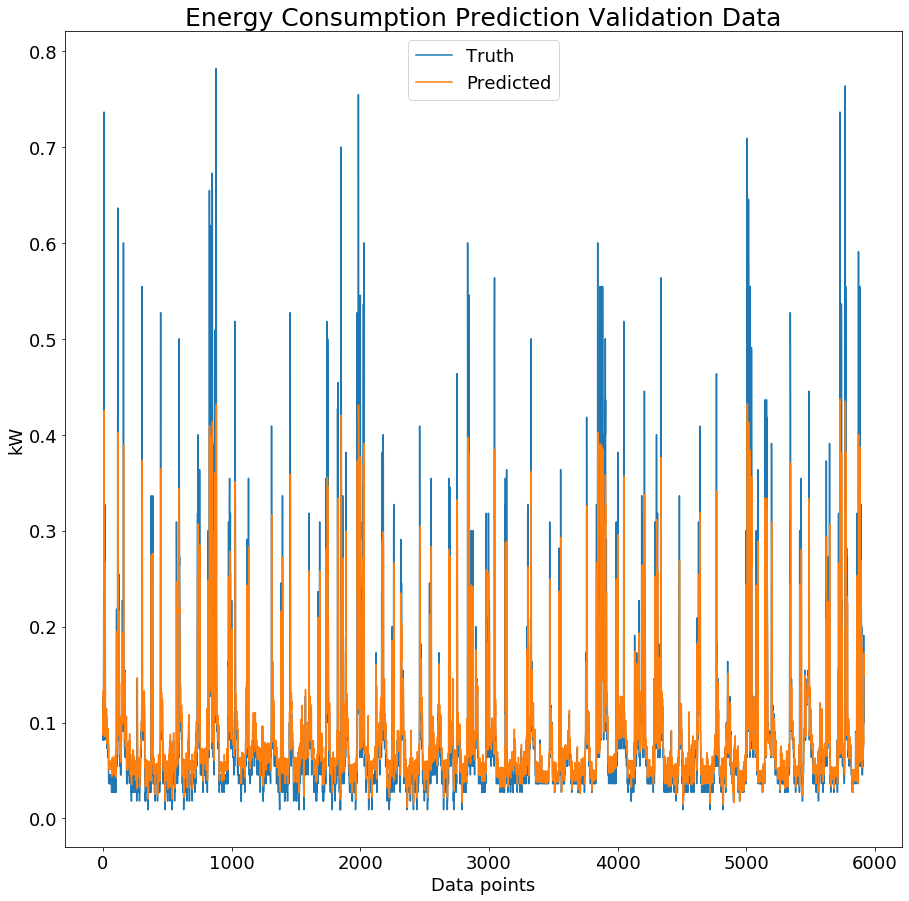

<Figure size 1080x1080 with 0 Axes>

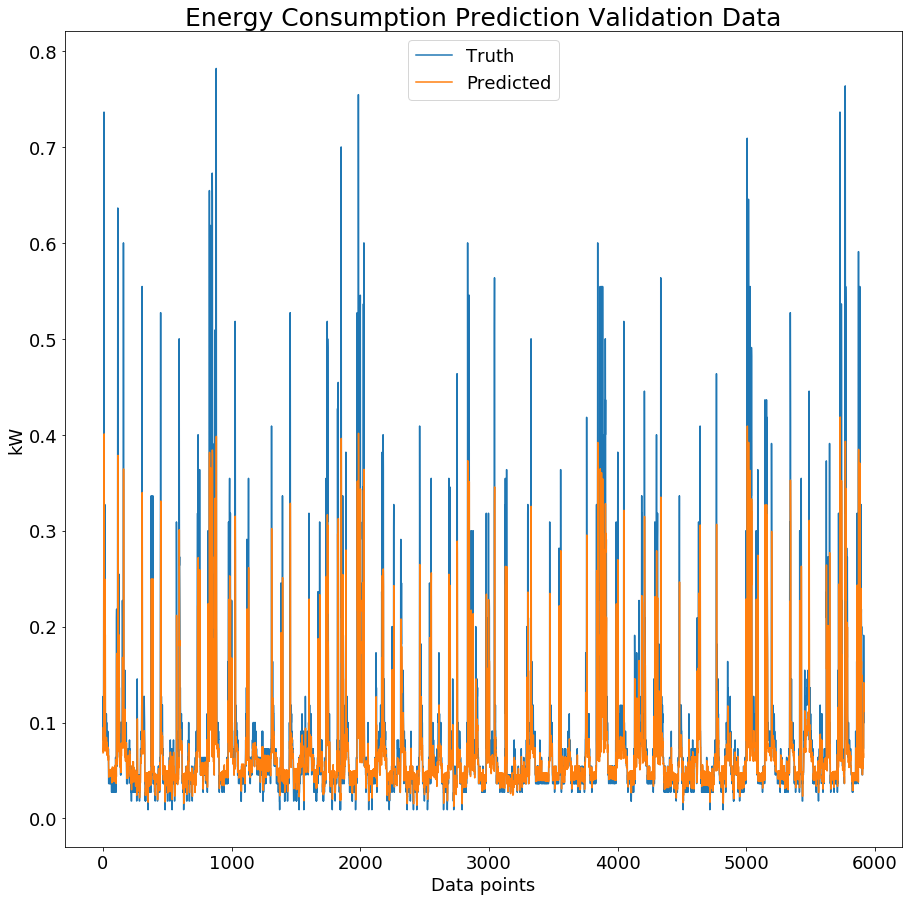

<Figure size 1080x1080 with 0 Axes>

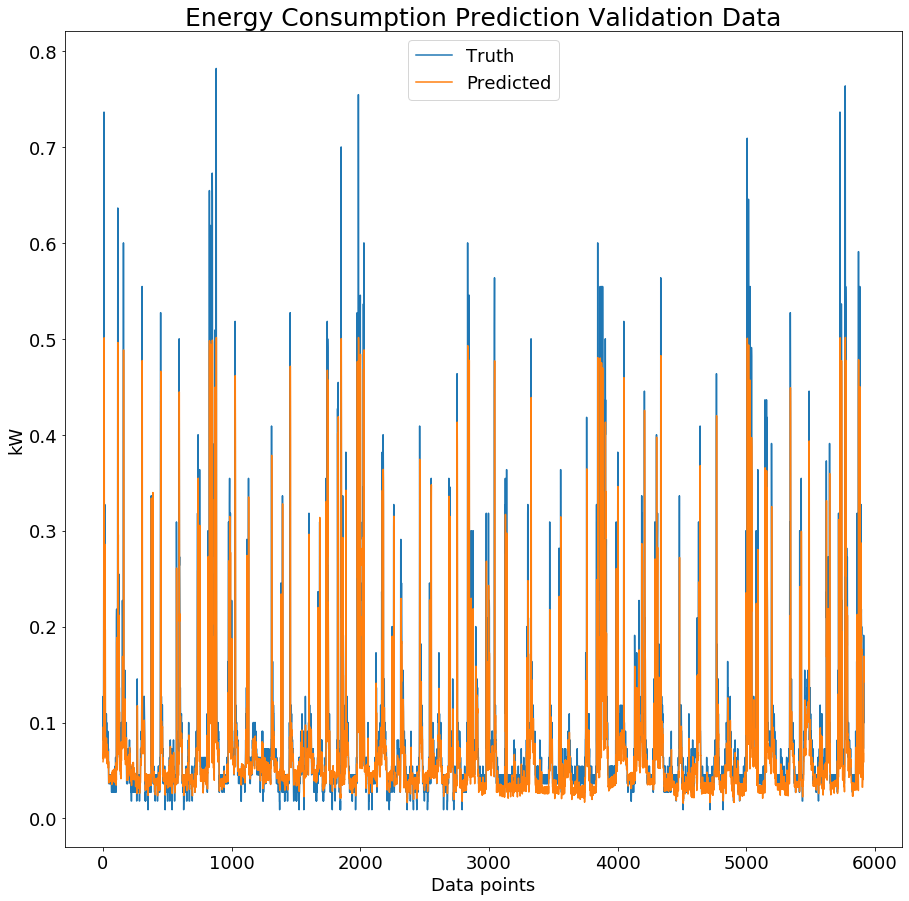

<Figure size 1080x1080 with 0 Axes>

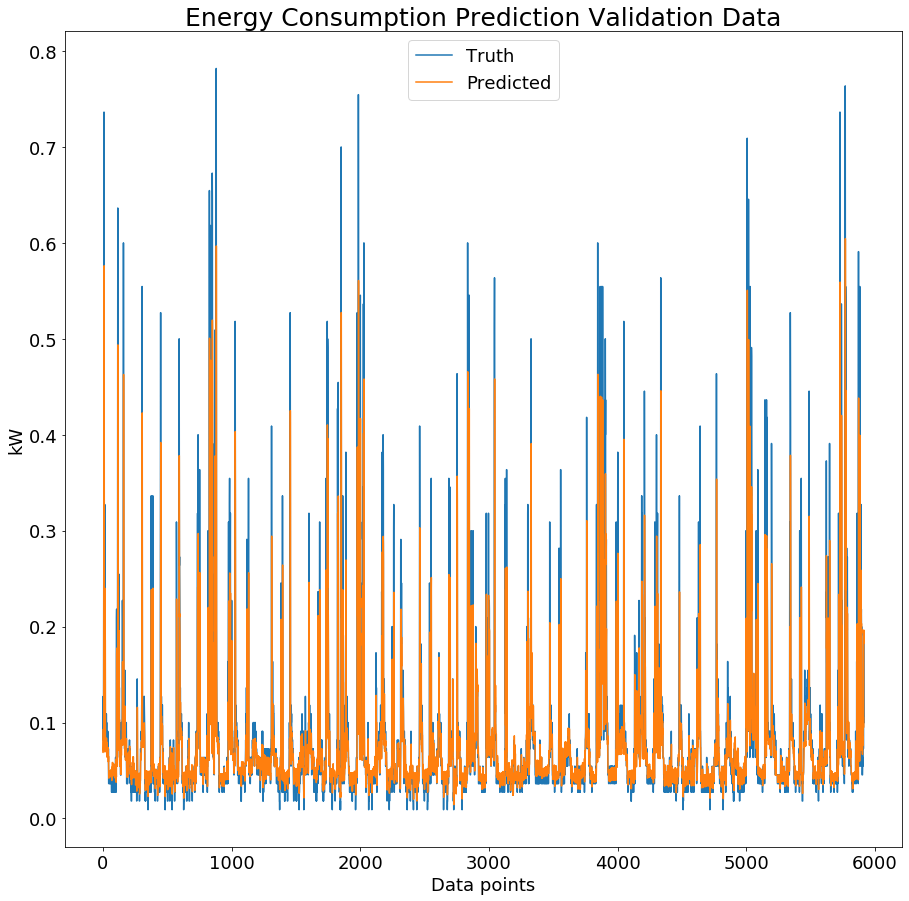

In [21]:
mae_txt = [0]
rmse_txt = [0]
rs_txt = [0]
mape_txt = [0]

folds = []

r_lista = []

for i in range(1,6): #6
    folds.append(i)
    
#MODEL
    model = None

    model = Sequential()

    model.add(Bidirectional(LSTM(7, return_sequences=True, activation='tanh', name='lstm1'), name = 'input'))
    
    model.add(Bidirectional(LSTM(7, return_sequences=True, activation='tanh', name='lstm2'), name = 'bi-lstm1'))
    
    model.add(Bidirectional(LSTM(7, return_sequences=True, activation='tanh', name='lstm3'), name = 'bi-lstm2'))
    
    model.add(Bidirectional(LSTM(7, return_sequences=True, activation='tanh', name='lstm4'), name = 'bi-lstm3'))
    
    model.add(Bidirectional(LSTM(7, return_sequences=True, activation='tanh', name='lstm5'), name = 'bi-lstm4'))
    
    model.add(BatchNormalization(name='Normalization'))

    model.add(Dropout(0.5))

    model.add(LSTM(1, input_shape=(timestep, 1), return_sequences=False, activation='sigmoid', name='Output'))
    
#COMPILE
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
    loss = 'mean_squared_error'
    lr = 0.0005
    opt = Adam(learning_rate=lr)
    model.compile(optimizer = opt, loss = loss, metrics=[r2])


#TRAIN    
    print('Train...')

    history = model.fit(np.concatenate(X_list_big[0:i], axis = 0), 
                        np.concatenate(y_list_big[0:i], axis = 0), 
                        batch_size=1000, 
                        epochs=1000, 
                        validation_data=[np.concatenate(X_list_big[i:i+1], axis = 0), 
                                         np.concatenate(y_list_big[i:i+1], axis = 0)],verbose = 0, 
                        callbacks = [es])
    
    plt.figure(figsize=(15,15))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'test'], loc='upper left', fontsize = 18)
    plt.xticks(rotation='horizontal')
    plt.yticks(rotation='horizontal')
    plt.xlabel('Epoch',fontsize=18, ha='center')
    plt.ylabel(loss,fontsize=18, ha='center')
    plt.title(loss + ', Train VS Test',fontsize=25, ha='center')
    plt.tick_params(labelsize=18)
    plt.savefig(newpath+ '/Loss_' + loss + '_Learning_' + str(lr) + '_Fold_' + str(i) + '.PNG')
    
    model.summary()
    
    model.trainable = False
    
    for layer in model.layers[:-2]:
        layer.trainable = False
    
    model.compile(optimizer = opt, loss = loss, metrics=[r2])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    history2 = model.fit(np.concatenate(X_list_small[0:i], axis = 0), 
                        np.concatenate(y_list_small[0:i], axis = 0),
                        batch_size=1000,
                        epochs=1000,
                        validation_data=[np.concatenate(X_list_small[i:i+1], axis = 0), 
                                         np.concatenate(y_list_small[i:i+1], axis = 0)], 
                                 callbacks = [es])
    model.summary()
    
    model.trainable = True
    for layer in model.layers[:-1]:
        layer.trainable = True
        
    #model.layers[5].trainable = False

    
        
    
    opt = Adam(learning_rate=0.000001)
    model.compile(optimizer = opt, loss = loss, metrics=[r2])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history3 = model.fit(np.concatenate(X_list_small[0:i], axis = 0), 
                        np.concatenate(y_list_small[0:i], axis = 0),
                        batch_size=1000,
                        epochs=1000,
                        validation_data=[np.concatenate(X_list_small[i:i+1], axis = 0), 
                                         np.concatenate(y_list_small[i:i+1], axis = 0)], 
                                 callbacks = [es])
    
    
#CALCULATE RESULTS    
    result = model.predict(X_val)
    result.shape
    
    result2 = result[:,:]#.flatten()
    y_val2 = y_val[:]#.flatten()
    
    plt.clf()
    plt.figure(figsize=(15,15))
    plt.plot(y_val2[:], label = 'Truth')
    plt.plot(result2[:], label = 'Predicted')
    plt.legend(fontsize = 18)
    plt.xticks(rotation='horizontal')
    plt.yticks(rotation='horizontal')
    plt.xlabel('Data points',fontsize=18, ha='center')
    plt.ylabel('kW',fontsize=18, ha='center')
    plt.title('Energy Consumption Prediction Validation Data',fontsize=25, ha='center')
    plt.tick_params(labelsize=18)
    plt.savefig(newpath+ '/Validation_' + loss + '_Learning_' + str(lr) + '_Fold_' + str(i) + '.PNG')
    
    turned_R = []
    turned_Y = []
    for p in range(0,len(y_val2)):
        turned_R.append(min_max_scaler.inverse_transform([[0,0,0,0,0,0,result2[p]]])[0][-1]*3600)
        turned_Y.append(min_max_scaler.inverse_transform([[0,0,0,0,0,0,y_val2[p]]])[0][-1]*3600)
        
    mae = mean_absolute_error(turned_Y,turned_R)
    rmse = sqrt(mean_squared_error(turned_Y,turned_R))
    rs = r2_score(turned_Y,turned_R)
    mape = mean_absolute_percentage_error(turned_Y,turned_R)
    
    r_lista.append([mae,rmse,rs,mape])

    print('Good Model','RMSE:', rmse, ' R^2:', rs, ' MAE:', mae, ' MAPE:', mape)
    

mae_txt[0] = r_lista[0][0]
rmse_txt[0] = r_lista[0][1]
rs_txt[0] = r_lista[0][2]
mape_txt[0] = r_lista[0][3]

for i in range(1,len(r_lista)):
    mae_txt.append(r_lista[i][0])
    rmse_txt.append(r_lista[i][1])
    rs_txt.append(r_lista[i][2])
    mape_txt.append(r_lista[i][3])
    
mae_avg = sum(mae_txt)/len(r_lista)
rmse_avg = sum(rmse_txt)/len(r_lista)
rs_avg = sum(rs_txt)/len(r_lista)
mape_avg = sum(mape_txt)/len(r_lista)


text = newpath+ '/' + loss + '_' + str(lr) + '.txt'
f= open(text,"w+")
f.write(str([loss,lr]))
f.write('\n')
f.write(str(['rmse','rs','mae','mape']))
f.write('\n')
f.write(str([rmse_avg,rs_avg,mae_avg,mape_avg]))
f.write('\n')
f.write(str(['RMSE: ', rmse_txt[:]]))
f.write('\n')
f.write(str(['R2: ', rs_txt[:]]))
f.write('\n')
f.write(str(['MAE: ', mae_txt[:]]))
f.write('\n')
f.write(str(['MApE: ', mape_txt[:]]))
f.write('\n')
f.close()

